In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import ticker
from scipy import optimize
plt.rc('text.latex', preamble=r'\usepackage{mathptmx}')

In [2]:
dirname = './02-04/'
betas = np.array([0, 45, 90, 135])
alphas = np.arange(0, 190, 20, dtype=int)

In [3]:
means = np.zeros((len(betas), len(alphas)))
stds  = np.zeros((len(betas), len(alphas)))

i = 0
for b in betas: 
    j = 0
    for a in alphas: 
        data = np.loadtxt(os.path.join(dirname, f'{a}-{b}.txt'))
        mean = np.mean(data, axis=0)[-1]
        std  = np.std(data, axis=0)[-1]
        means[i, j] = mean
        stds[i, j]  = std

        j += 1
    i += 1

## Curve fitting

In [4]:
# Equation (12) in arXiv:quant-ph/0205171
def counts(X, th, ph, A, C): 
    a, b = X
    
    # Degrees -> radians
    alpha  = np.pi * a / 180 
    beta   = np.pi * b / 180
    thetal = np.pi * th / 180
    phim   = np.pi * ph / 180

    res = A * (
            np.power(np.sin(alpha) * np.sin(beta) * np.cos(thetal), 2)
            + np.power(np.cos(alpha) * np.cos(beta) * np.sin(thetal), 2)
            + (1/4) * np.sin(2 * alpha) * np.sin(2 * beta) * np.sin(2 * thetal) * np.cos(phim)
        ) + C

    return res.flatten()

# Perform curve fit
X = np.meshgrid(alphas, betas)
popt, pcov = optimize.curve_fit(counts, X, means.flatten(), 
                                p0=[45, 0, 1900, 15], 
                                bounds=([0, 0, 0, 0],
                                        [360, 360, np.inf, np.inf]))

# Print best fit values
pnames = ['theta_l', 'phi_m', 'A', 'C']
for pname, p in zip(pnames, popt):
    print(pname.ljust(10, ' '), str(p).rjust(10, ' '))

theta_l    43.07667325233803
phi_m      50.06081985606944
A          1893.9849035311156
C          15.716953875270262


## Plot

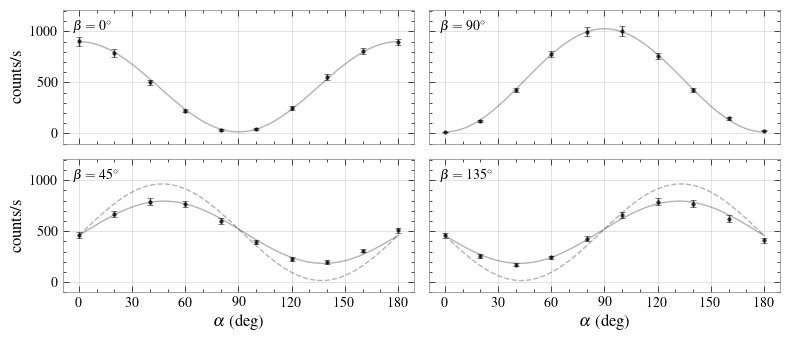

In [5]:
beta_grid = np.reshape(betas, (2,2))

fig, ax = plt.subplots(nrows=np.shape(beta_grid)[0], ncols=np.shape(beta_grid)[1], 
                       figsize=(8,3.5))

acont = np.linspace(0, 180, 100)

i = 0
for i in range(np.shape(beta_grid)[0]):
    for j in range(np.shape(beta_grid)[1]):

        k = 2*j + i # to keep track of which beta we're on

        # Plot data
        ax[i, j].errorbar(alphas, means[k, :], yerr=stds[k, :], 
                    fmt='o', 
                    ms=2.5, 
                    alpha=0.7,
                    capsize=2, 
                    color='black', linewidth=1)

        # Plot best fit
        ax[i, j].plot(acont, counts((acont, betas[k]), *popt),
                color='black',
                linewidth=1, 
                alpha=0.3)

        # Global vertical limits
        ax[i, j].set_ylim(-100, 1210)

        # Label each subplot with beta
        ax[i, j].text(0.03, 0.85, f'$\\beta = {betas[k]}^\\circ$', transform=ax[i, j].transAxes)

        ax[i, j].xaxis.set_major_locator(ticker.MultipleLocator(30))
        ax[i, j].xaxis.set_minor_locator(ticker.MultipleLocator(10))

        ax[i, j].yaxis.set_major_locator(ticker.MultipleLocator(500))
        ax[i, j].yaxis.set_minor_locator(ticker.MultipleLocator(100))

        # Hide axis labels on inner plots
        if j == 0: 
            ax[i, j].set_ylabel('counts/s')
        
        if i == 0:
            ax[i, j].xaxis.set_ticklabels([])

        if j == 1:
            ax[i, j].yaxis.set_ticklabels([])

        # Plot phi = 0
        if i == 1:           
            ax[i, j].plot(acont, counts((acont, betas[k]), popt[0], 0, popt[2], popt[3]),
                    color='black',
                    linewidth=1, 
                    linestyle='dashed',
                    alpha=0.3)
            ax[i, j].set_xlabel('$\\alpha$ (deg)')

plt.tight_layout()
plt.savefig('./fig/acquisition.pdf')
plt.savefig('./fig/acquisition.png')